## Experimenting with EEG data for activation steering
Author: Rishika Bose\
Data from: 
- https://openneuro.org/datasets/ds005530/versions/1.0.5

Trying to clean data and try out activation steering for AISC project 'Leveraging Neuroscience for AI Safety'.

In [19]:
import mne
import numpy as np
import os
import json
from datetime import datetime

### Cleaning the data
**Figuring out how to load, process and save the EEG data to use for the experiments.**

Testing how to load the data:

Extracting parameters from ./ds005530/sub-01122021301/eeg/sub-01122021301_task-sleep_run-01_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 15598889  =      0.000 ... 31197.778 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: F3, F4, C3, C4, O1, O2, LEOG, REOG, LEMG, REMG
 chs: 10 EEG
 custom_ref_applied: False
 dig: 9 items (3 Cardinal, 6 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-11-29 22:53:02 UTC
 nchan: 10
 projs: []
 sfreq: 500.0 Hz
>


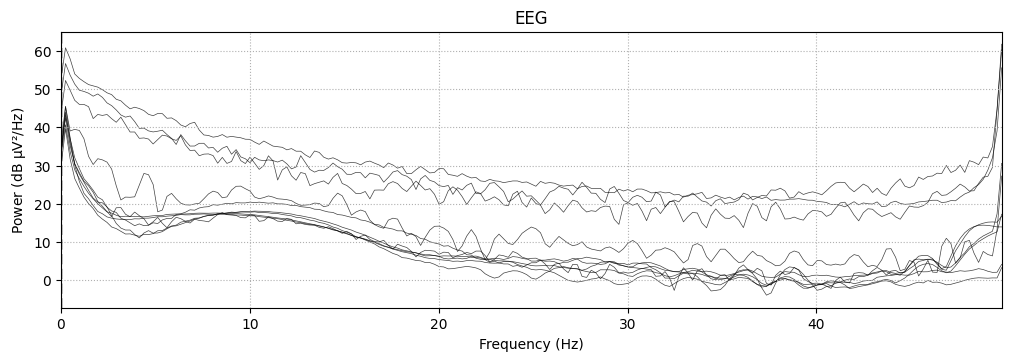

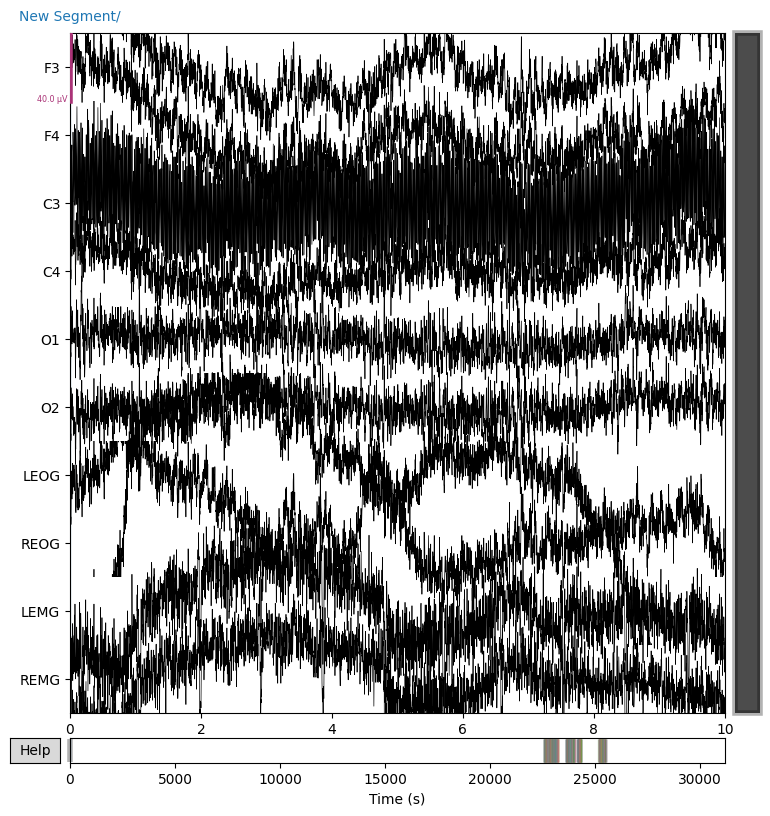

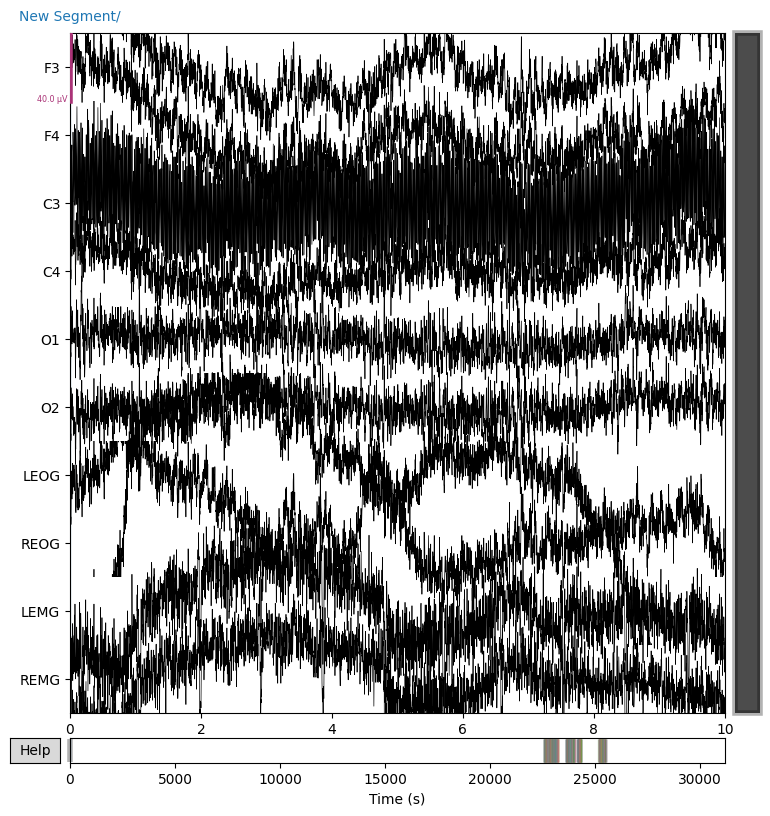

In [4]:
# Path to the .vhdr file
vhdr_file = './ds005530/sub-01122021301/eeg/sub-01122021301_task-sleep_run-01_eeg.vhdr'

# Load EEG data
raw = mne.io.read_raw_brainvision(vhdr_file, preload=True)

# Apply standard electrode montage to fix missing channel locations
raw.set_montage('standard_1020', on_missing='ignore')  

# Print EEG info
print(raw.info)

# Plot EEG signals
raw.plot(duration=10, n_channels=10)

In [25]:
#A function to get the EEG data from all subjects, and save it to a dictionary (along with metadata).
def process_eeg_files(root_folder):
    """
    Processes EEG data files using BrainVision .vhdr files and stores results in a dictionary.

    Parameters:
    root_folder (str): Path to the folder containing EEG data subfolders.
    
    Returns:
    dict: A dictionary containing EEG processing results for each file.
    """
    eeg_files = []
    results = {}

    # Walk through directories, but ignore .git and annex folders
    for subdir, _, files in os.walk(root_folder):
        if ".git" in subdir or "annex" in subdir:
            continue  # Skip git-related directories

        if 'eeg' in subdir.lower():  # Ensures search is limited to 'eeg' directories
            for file in files:
                if file.endswith('.eeg'):
                    eeg_files.append(os.path.join(subdir, file))

    if not eeg_files:
        print("No EEG files found. Check the dataset path.")
        return {}

    # Iterate through each EEG file
    for eeg_file in eeg_files:
        file_results = {"info": None, "raw_data": None, "psd": None, "events": None}

        try:
            # Construct the corresponding .vhdr file path
            vhdr_file = eeg_file.replace('.eeg', '.vhdr')

            # Ensure the .vhdr file exists
            if not os.path.exists(vhdr_file):
                file_results["error"] = f"Missing .vhdr file for {eeg_file}"
                results[eeg_file] = file_results
                continue  

            # Load EEG data using the .vhdr file
            raw = mne.io.read_raw_brainvision(vhdr_file, preload=True)

            # Store EEG info and convert datetime if present
            file_results["info"] = {key: value.isoformat() if isinstance(value, datetime) else value
                                    for key, value in raw.info.items()}

            # Extract power spectral density (PSD)
            psd_data, freqs = raw.compute_psd(fmax=50)
            file_results["psd"] = {"psd_data": psd_data.tolist(), "frequencies": freqs.tolist()}

            # Extract events if available
            events, _ = mne.events_from_annotations(raw)
            file_results["events"] = len(events)  # Store number of events

        except Exception as e:
            file_results["error"] = f"Error processing {eeg_file}: {e}"

        # Save the results in the dictionary
        results[eeg_file] = file_results

    return results

In [26]:
#Extract the data
results = process_eeg_files("./ds005530")

Extracting parameters from ./ds005530\sub-01122021301\eeg\sub-01122021301_task-sleep_run-01_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 15598889  =      0.000 ... 31197.778 secs...
Effective window size : 4.096 (s)
Extracting parameters from ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-01_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 324779  =      0.000 ...   649.558 secs...
Effective window size : 4.096 (s)
Extracting parameters from ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-02_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 124439  =      0.000 ...   248.878 secs...
Effective window size : 4.096 (s)
Extracting parameters from ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 749109  =      0.000 ...  1498.218 secs...
Effective window size : 4.096 (s)
Extracting parameters from ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sle

In [ ]:
#Alternative function that prints out output

def process_eeg_files(root_folder):
    """
    Processes EEG data files using BrainVision .vhdr files and performs basic checks.

    Parameters:
    root_folder (str): Path to the folder containing EEG data subfolders.
    """
    eeg_files = []

    # Walk through directories, but ignore .git and annex folders
    for subdir, _, files in os.walk(root_folder):
        if ".git" in subdir or "annex" in subdir:
            continue  # Skip git-related directories

        if 'eeg' in subdir.lower():  # Ensures search is limited to 'eeg' directories
            for file in files:
                if file.endswith('.eeg'):
                    eeg_files.append(os.path.join(subdir, file))

    if not eeg_files:
        print("No EEG files found. Check the dataset path.")
        return

    # Iterate through each EEG file
    for eeg_file in eeg_files:
        print(f"\nProcessing: {eeg_file}")

        try:
            # Construct the corresponding .vhdr file path
            vhdr_file = eeg_file.replace('.eeg', '.vhdr')

            # Ensure the .vhdr file exists
            if not os.path.exists(vhdr_file):
                print(f"❌ Missing .vhdr file for {eeg_file}, skipping.")
                continue  

            print(f"✅ Found .vhdr file: {vhdr_file}")

            # Load EEG data using the .vhdr file
            raw = mne.io.read_raw_brainvision(vhdr_file, preload=True)

            # Print EEG Info
            print("\nEEG Info:")
            print(raw.info)

            # Plot raw data (first 10 channels)
            print("\nPlotting raw data...")
            raw.plot(duration=10, n_channels=10)

            # Plot power spectral density
            print("\nPlotting power spectral density...")
            raw.plot_psd(fmax=50)

            # Extract events if available
            print("\nExtractig events...")
            events, _ = mne.events_from_annotations(raw)
            print(f"✅ Found {len(events)} events.")

        except Exception as e:
            print(f"❌ Error processing {eeg_file}: {e}")

# Example usage:
# process_eeg_files("./ds005530")


Processing: ./ds005530\sub-01122021301\eeg\sub-01122021301_task-sleep_run-01_eeg.eeg
✅ Found .vhdr file: ./ds005530\sub-01122021301\eeg\sub-01122021301_task-sleep_run-01_eeg.vhdr
Extracting parameters from ./ds005530\sub-01122021301\eeg\sub-01122021301_task-sleep_run-01_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 15598889  =      0.000 ... 31197.778 secs...

EEG Info:
<Info | 7 non-empty values
 bads: []
 ch_names: F3, F4, C3, C4, O1, O2, LEOG, REOG, LEMG, REMG
 chs: 10 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-11-29 22:53:02 UTC
 nchan: 10
 projs: []
 sfreq: 500.0 Hz
>

Plotting raw data...


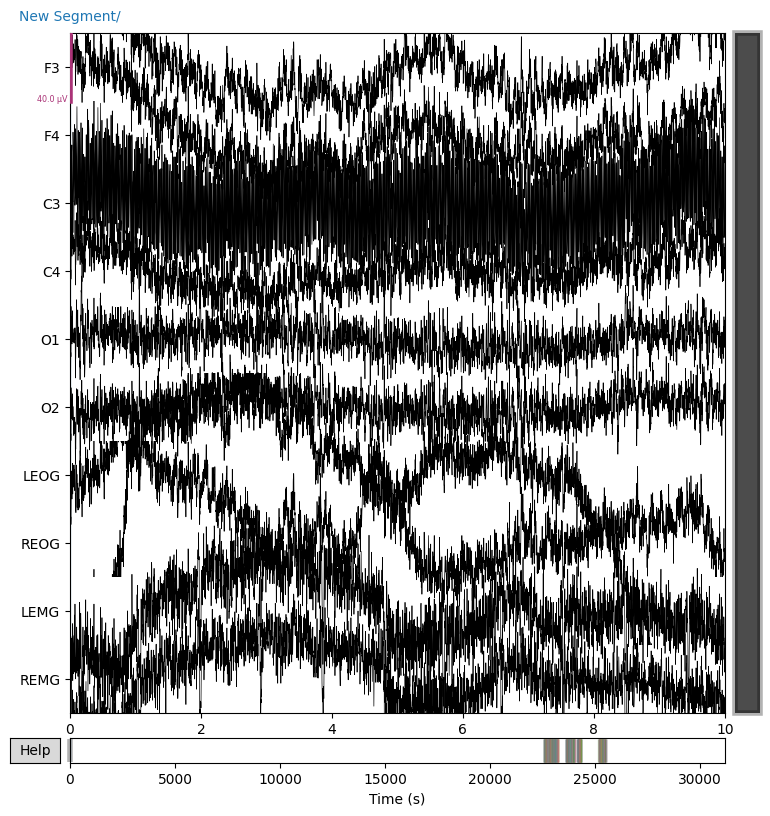


Plotting power spectral density...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).

Extractig events...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S102', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106', 'Stimulus/S108', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S114', 'Stimulus/S117', 'Stimulus/S118', 'Stimulus/S127', 'Stimulus/S128', 'Stimulus/S129', 'Stimulus/S134', 'Stimulus/S135', 'Stimulus/S138', 'Stimulus/S139', 'Stimulus/S140', 'Stimulus/S141', 'Stimulus/S142', 'Stimulus/S145', 'Stimulus/S146', 'Stimulus/S148', 'Stimulus/S199']
✅ Found 482 events.

Processing: ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-01_eeg.eeg
✅ Found .vhdr file: ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-01_eeg.vhdr
Extracting parameters from ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-01_eeg.vhdr...
Setting

C:\Users\rikib\AppData\Local\Temp\ipykernel_2992\2456613819.py:55: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
C:\Users\rikib\miniconda3\envs\fastai\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)



EEG Info:
<Info | 7 non-empty values
 bads: []
 ch_names: F3, F4, C3, C4, O1, O2, LEOG, REOG, LEMG, REMG
 chs: 10 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-11-01 21:59:56 UTC
 nchan: 10
 projs: []
 sfreq: 500.0 Hz
>

Plotting raw data...


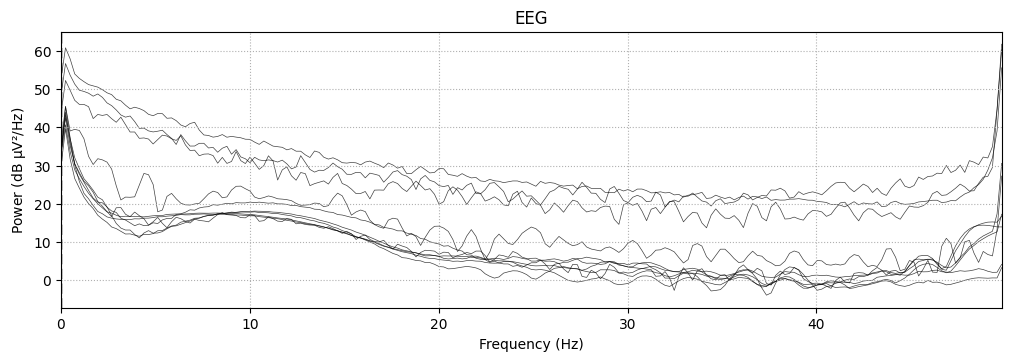

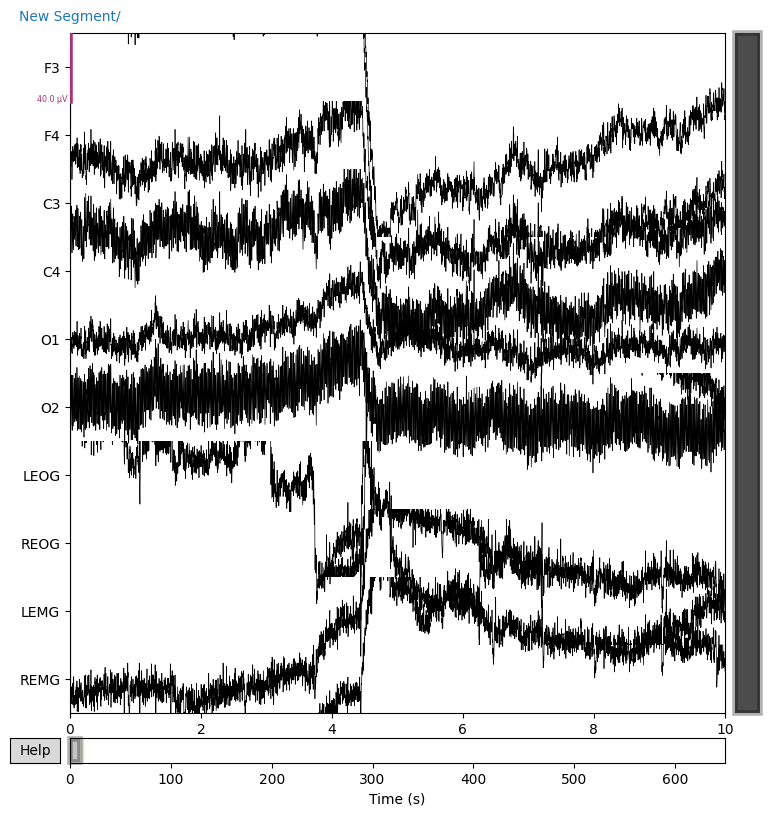


Plotting power spectral density...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).

Extractig events...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S141', 'Stimulus/S142']
✅ Found 3 events.

Processing: ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-02_eeg.eeg
✅ Found .vhdr file: ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-02_eeg.vhdr
Extracting parameters from ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-02_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 124439  =      0.000 ...   248.878 secs...

EEG Info:
<Info | 7 non-empty values
 bads: []
 ch_names: F3, F4, C3, C4, O1, O2, LEOG, REOG, LEMG, REMG
 chs: 10 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-11-02 03:27:28 UTC
 nchan: 10
 projs: []
 sfreq: 500.0 Hz
>

Plotting raw data...


C:\Users\rikib\AppData\Local\Temp\ipykernel_2992\2456613819.py:55: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
C:\Users\rikib\miniconda3\envs\fastai\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


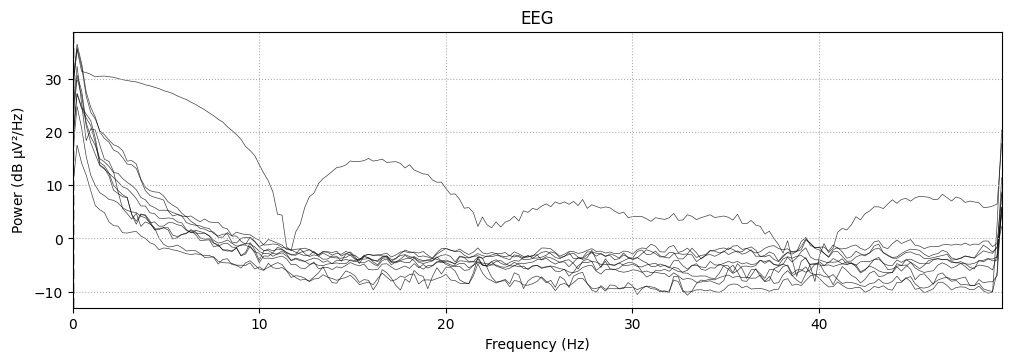

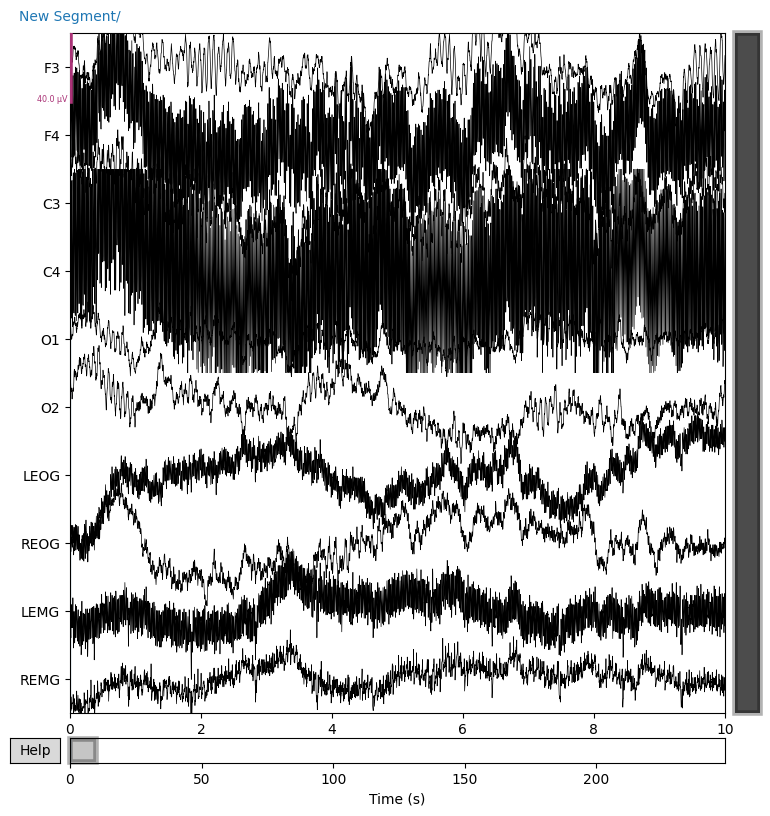


Plotting power spectral density...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).

Extractig events...
Used Annotations descriptions: ['New Segment/']
✅ Found 1 events.

Processing: ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-03_eeg.eeg
✅ Found .vhdr file: ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-03_eeg.vhdr
Extracting parameters from ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 749109  =      0.000 ...  1498.218 secs...


C:\Users\rikib\AppData\Local\Temp\ipykernel_2992\2456613819.py:55: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
C:\Users\rikib\miniconda3\envs\fastai\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)



EEG Info:
<Info | 7 non-empty values
 bads: []
 ch_names: F3, F4, C3, C4, O1, O2, LEOG, REOG, LEMG, REMG
 chs: 10 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-11-02 03:43:38 UTC
 nchan: 10
 projs: []
 sfreq: 500.0 Hz
>

Plotting raw data...


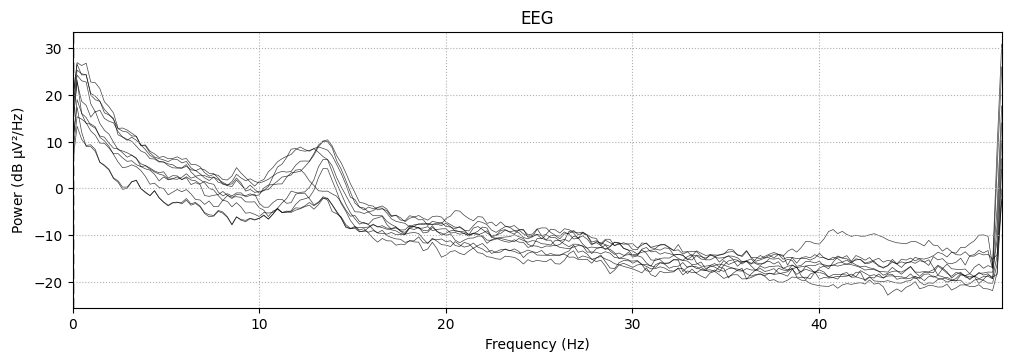

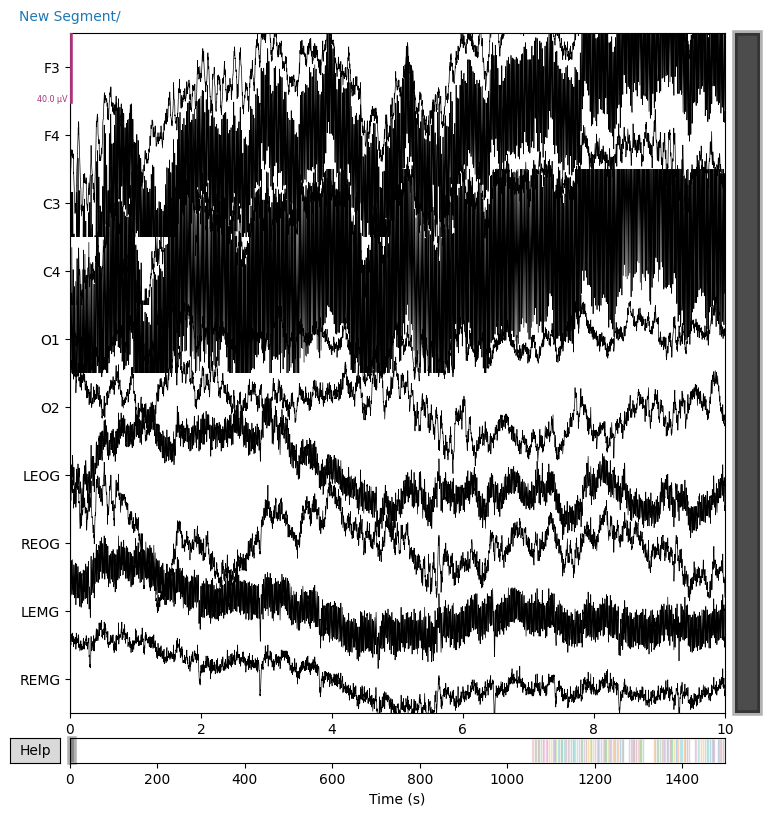


Plotting power spectral density...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).

Extractig events...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S106', 'Stimulus/S107', 'Stimulus/S109', 'Stimulus/S110', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S117', 'Stimulus/S118', 'Stimulus/S121', 'Stimulus/S123', 'Stimulus/S127', 'Stimulus/S129', 'Stimulus/S130', 'Stimulus/S131', 'Stimulus/S137', 'Stimulus/S138', 'Stimulus/S139', 'Stimulus/S143', 'Stimulus/S144', 'Stimulus/S146', 'Stimulus/S147']
✅ Found 117 events.

Processing: ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-04_eeg.eeg
✅ Found .vhdr file: ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-04_eeg.vhdr
Extracting parameters from ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-04_eeg.vhdr...
Setting channel info str

C:\Users\rikib\AppData\Local\Temp\ipykernel_2992\2456613819.py:55: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
C:\Users\rikib\miniconda3\envs\fastai\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)



EEG Info:
<Info | 7 non-empty values
 bads: []
 ch_names: F3, F4, C3, C4, O1, O2, LEOG, REOG, LEMG, REMG
 chs: 10 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-11-02 04:29:54 UTC
 nchan: 10
 projs: []
 sfreq: 500.0 Hz
>

Plotting raw data...


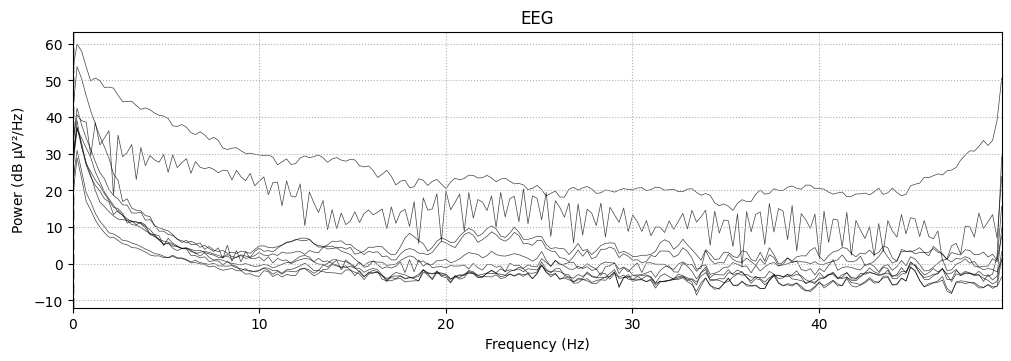

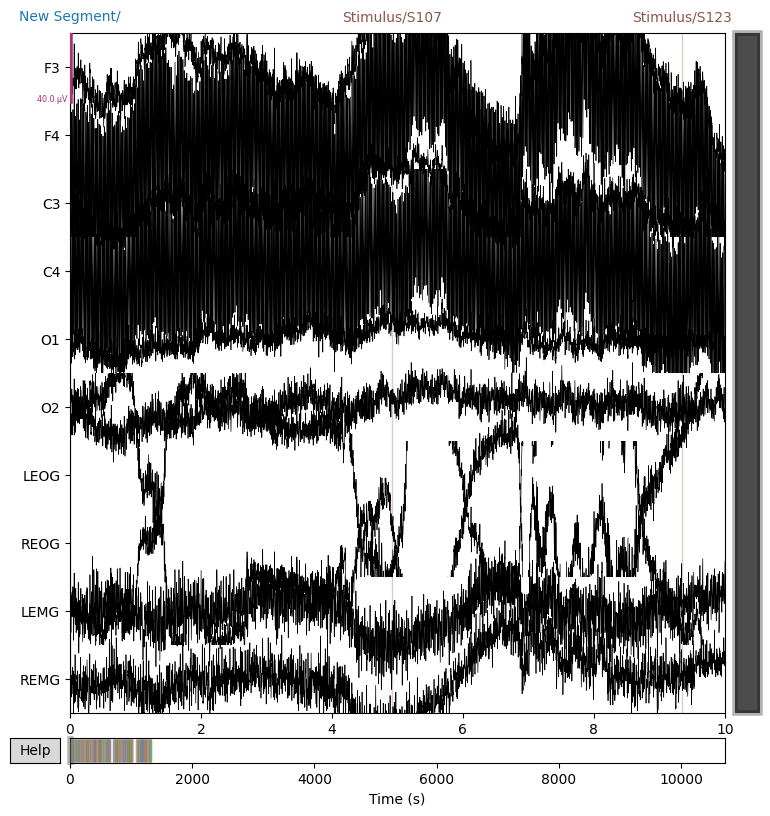


Plotting power spectral density...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).

Extractig events...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S106', 'Stimulus/S107', 'Stimulus/S109', 'Stimulus/S110', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S117', 'Stimulus/S118', 'Stimulus/S121', 'Stimulus/S123', 'Stimulus/S127', 'Stimulus/S129', 'Stimulus/S130', 'Stimulus/S131', 'Stimulus/S137', 'Stimulus/S138', 'Stimulus/S139', 'Stimulus/S143', 'Stimulus/S144', 'Stimulus/S146', 'Stimulus/S147']
✅ Found 362 events.

Processing: ./ds005530\sub-06102021301\eeg\sub-06102021301_task-sleep_run-01_eeg.eeg
✅ Found .vhdr file: ./ds005530\sub-06102021301\eeg\sub-06102021301_task-sleep_run-01_eeg.vhdr
Extracting parameters from ./ds005530\sub-06102021301\eeg\sub-06102021301_task-sleep_run-01_eeg.vhdr...
Setting channel info str

C:\Users\rikib\AppData\Local\Temp\ipykernel_2992\2456613819.py:55: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
C:\Users\rikib\miniconda3\envs\fastai\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)



EEG Info:
<Info | 7 non-empty values
 bads: []
 ch_names: F3, F4, C3, C4, O1, O2, LEOG, REOG, LEMG, REMG
 chs: 10 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-10-04 23:27:19 UTC
 nchan: 10
 projs: []
 sfreq: 500.0 Hz
>

Plotting raw data...


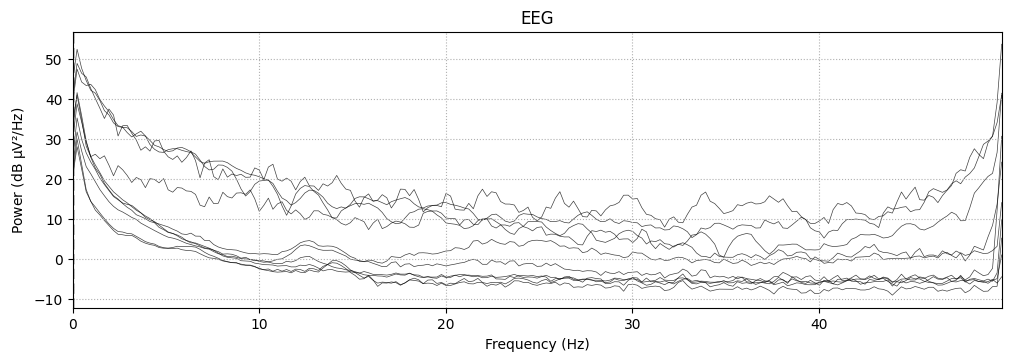

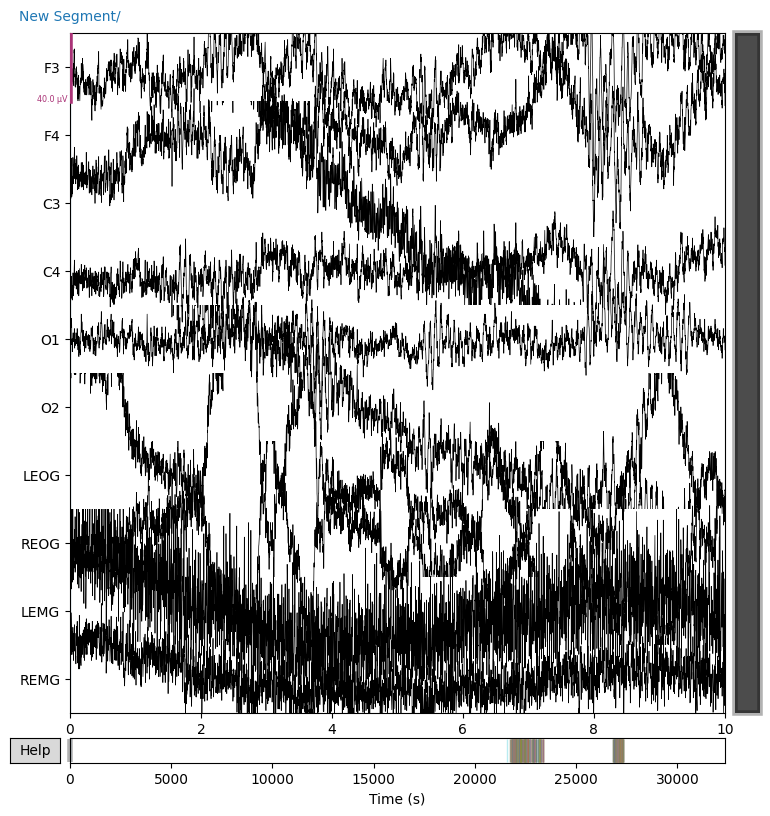


Plotting power spectral density...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


KeyboardInterrupt: 

In [13]:
process_eeg_files("./ds005530")

Processing: ./ds005530\.git\annex\objects\045\c9f\SHA256E-s319298800--ec01e874f2bed2a8fa969d7386946038e419d96ee41a5ef99ea3e40c1cd05dc2.eeg\SHA256E-s319298800--ec01e874f2bed2a8fa969d7386946038e419d96ee41a5ef99ea3e40c1cd05dc2.eeg
Missing .vhdr file for ./ds005530\.git\annex\objects\045\c9f\SHA256E-s319298800--ec01e874f2bed2a8fa969d7386946038e419d96ee41a5ef99ea3e40c1cd05dc2.eeg\SHA256E-s319298800--ec01e874f2bed2a8fa969d7386946038e419d96ee41a5ef99ea3e40c1cd05dc2.eeg, skipping.
Processing: ./ds005530\.git\annex\objects\0c5\4f4\SHA256E-s330156600--e0895318aac8c0347027a618e32a6b51efaede1f34cb9165676e1a6fbb92e40c.eeg\SHA256E-s330156600--e0895318aac8c0347027a618e32a6b51efaede1f34cb9165676e1a6fbb92e40c.eeg
Missing .vhdr file for ./ds005530\.git\annex\objects\0c5\4f4\SHA256E-s330156600--e0895318aac8c0347027a618e32a6b51efaede1f34cb9165676e1a6fbb92e40c.eeg\SHA256E-s330156600--e0895318aac8c0347027a618e32a6b51efaede1f34cb9165676e1a6fbb92e40c.eeg, skipping.
Processing: ./ds005530\.git\annex\objects\0d

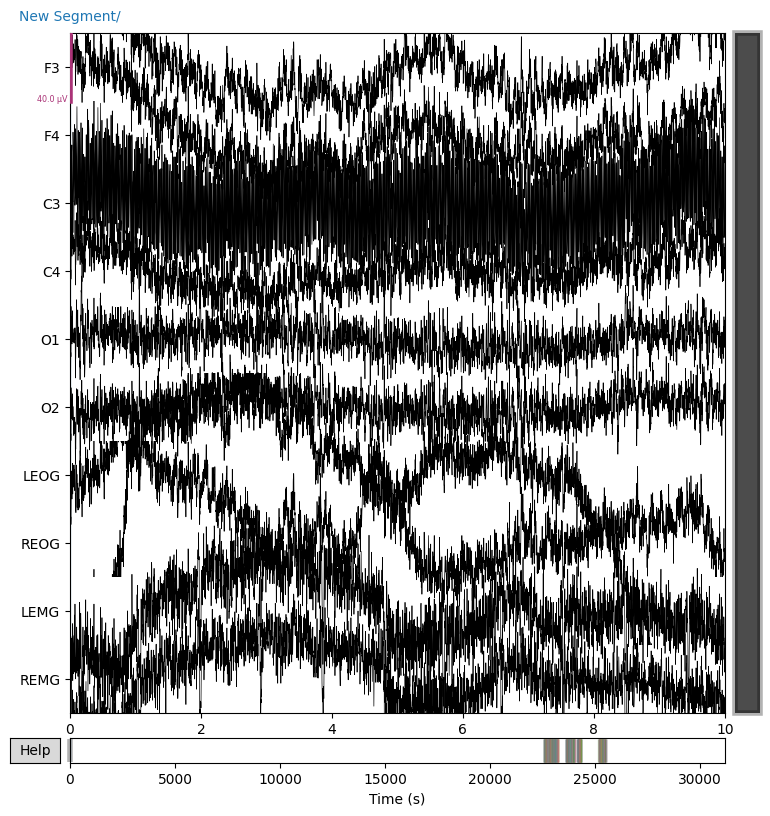

Plotting power spectral density...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Extracting events...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S102', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106', 'Stimulus/S108', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S114', 'Stimulus/S117', 'Stimulus/S118', 'Stimulus/S127', 'Stimulus/S128', 'Stimulus/S129', 'Stimulus/S134', 'Stimulus/S135', 'Stimulus/S138', 'Stimulus/S139', 'Stimulus/S140', 'Stimulus/S141', 'Stimulus/S142', 'Stimulus/S145', 'Stimulus/S146', 'Stimulus/S148', 'Stimulus/S199']
Found 482 events.
Processing: ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-01_eeg.eeg
Extracting parameters from ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-01_eeg.vhdr...
Setting channel info structure...


C:\Users\rikib\AppData\Local\Temp\ipykernel_2992\4081865487.py:41: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
C:\Users\rikib\miniconda3\envs\fastai\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Reading 0 ... 324779  =      0.000 ...   649.558 secs...
EEG Info:
<Info | 7 non-empty values
 bads: []
 ch_names: F3, F4, C3, C4, O1, O2, LEOG, REOG, LEMG, REMG
 chs: 10 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-11-01 21:59:56 UTC
 nchan: 10
 projs: []
 sfreq: 500.0 Hz
>
Plotting raw data...


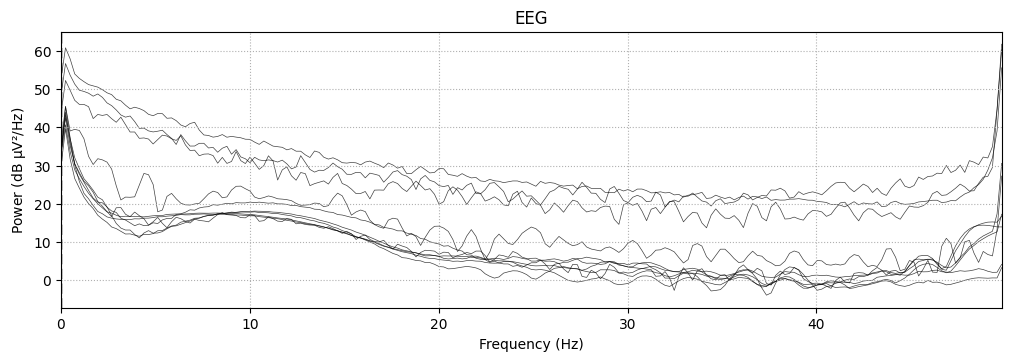

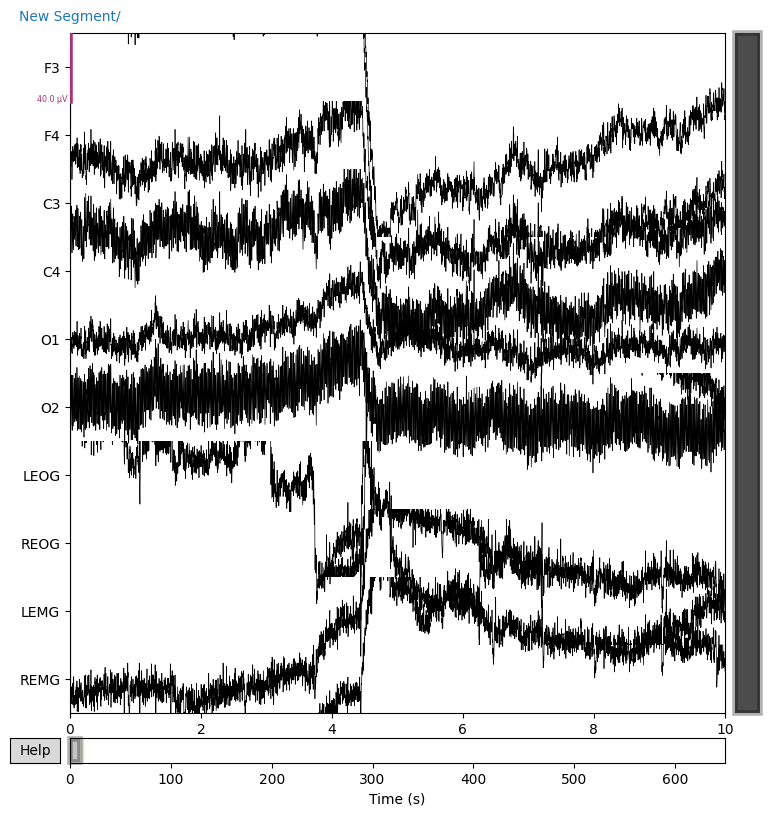

Plotting power spectral density...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Extracting events...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S141', 'Stimulus/S142']
Found 3 events.
Processing: ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-02_eeg.eeg
Extracting parameters from ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-02_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 124439  =      0.000 ...   248.878 secs...
EEG Info:
<Info | 7 non-empty values
 bads: []
 ch_names: F3, F4, C3, C4, O1, O2, LEOG, REOG, LEMG, REMG
 chs: 10 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-11-02 03:27:28 UTC
 nchan: 10
 projs: []
 sfreq: 500.0 Hz
>
Plotting raw data...


C:\Users\rikib\AppData\Local\Temp\ipykernel_2992\4081865487.py:41: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
C:\Users\rikib\miniconda3\envs\fastai\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


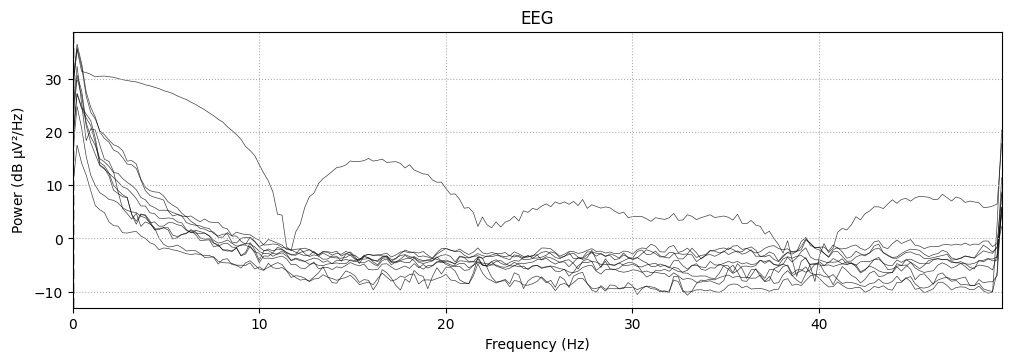

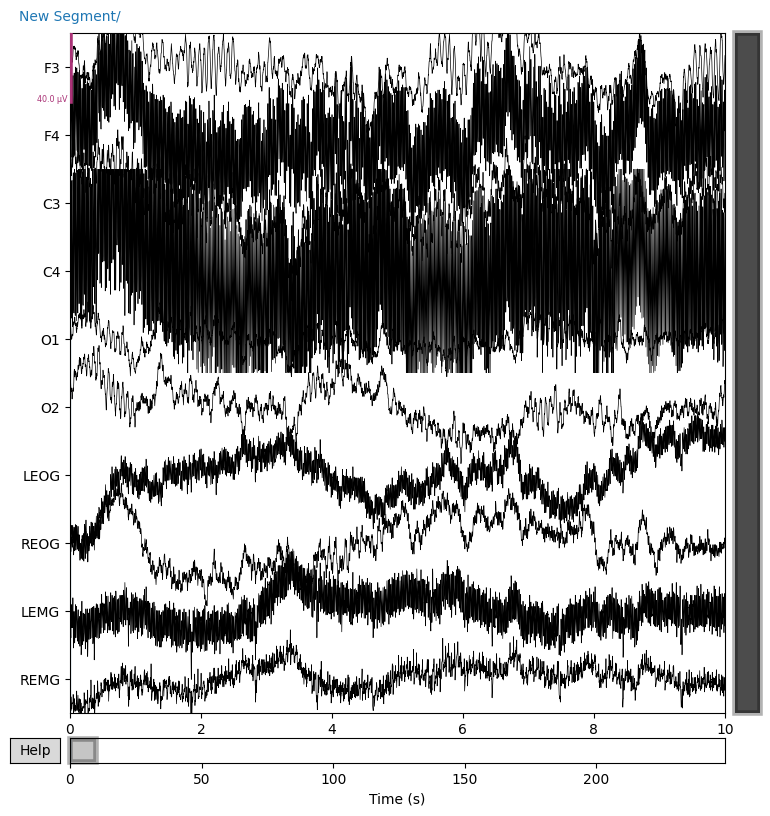

Plotting power spectral density...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Extracting events...
Used Annotations descriptions: ['New Segment/']
Found 1 events.
Processing: ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-03_eeg.eeg
Extracting parameters from ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 749109  =      0.000 ...  1498.218 secs...


C:\Users\rikib\AppData\Local\Temp\ipykernel_2992\4081865487.py:41: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
C:\Users\rikib\miniconda3\envs\fastai\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


EEG Info:
<Info | 7 non-empty values
 bads: []
 ch_names: F3, F4, C3, C4, O1, O2, LEOG, REOG, LEMG, REMG
 chs: 10 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-11-02 03:43:38 UTC
 nchan: 10
 projs: []
 sfreq: 500.0 Hz
>
Plotting raw data...


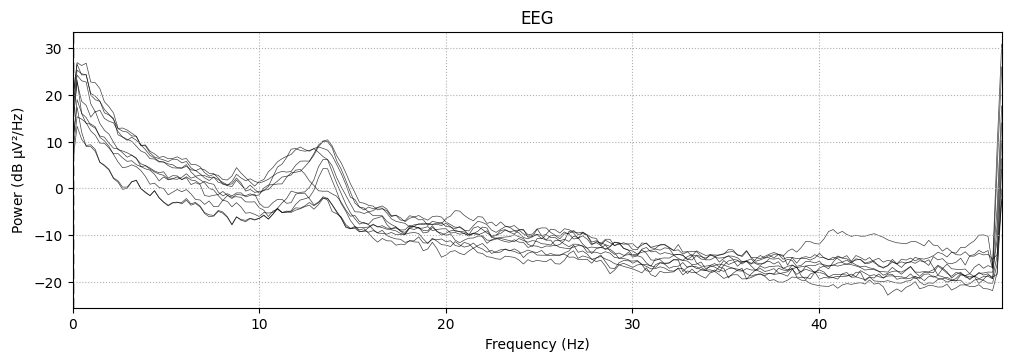

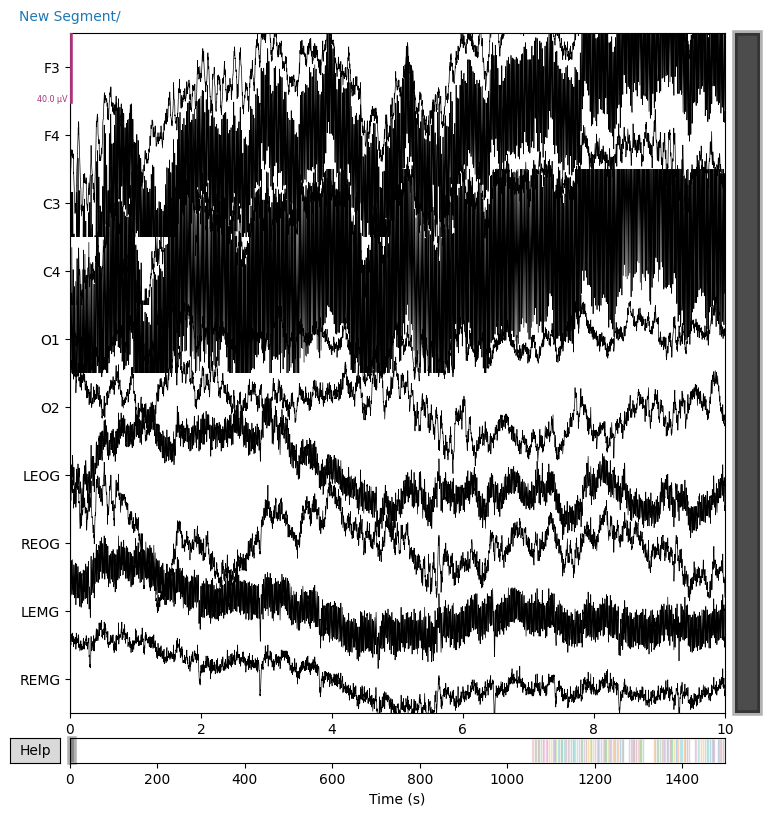

Plotting power spectral density...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Extracting events...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S106', 'Stimulus/S107', 'Stimulus/S109', 'Stimulus/S110', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S117', 'Stimulus/S118', 'Stimulus/S121', 'Stimulus/S123', 'Stimulus/S127', 'Stimulus/S129', 'Stimulus/S130', 'Stimulus/S131', 'Stimulus/S137', 'Stimulus/S138', 'Stimulus/S139', 'Stimulus/S143', 'Stimulus/S144', 'Stimulus/S146', 'Stimulus/S147']
Found 117 events.
Processing: ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-04_eeg.eeg
Extracting parameters from ./ds005530\sub-03112021304\eeg\sub-03112021304_task-sleep_run-04_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 5358069  =      0.000 ... 10716.138 secs...


C:\Users\rikib\AppData\Local\Temp\ipykernel_2992\4081865487.py:41: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
C:\Users\rikib\miniconda3\envs\fastai\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


EEG Info:
<Info | 7 non-empty values
 bads: []
 ch_names: F3, F4, C3, C4, O1, O2, LEOG, REOG, LEMG, REMG
 chs: 10 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-11-02 04:29:54 UTC
 nchan: 10
 projs: []
 sfreq: 500.0 Hz
>
Plotting raw data...


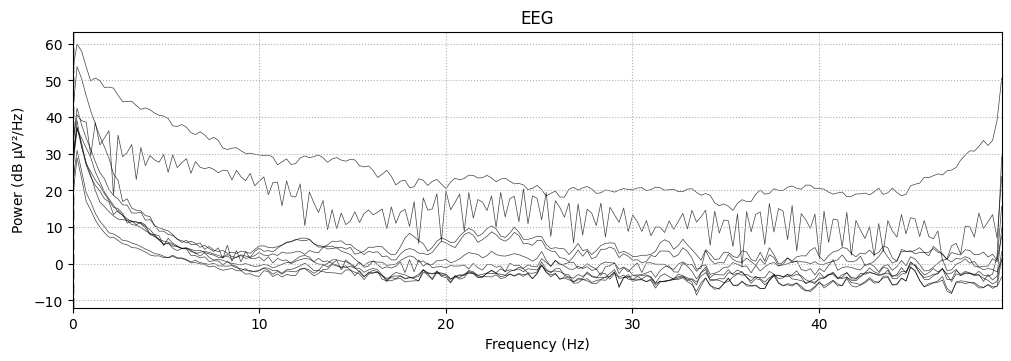

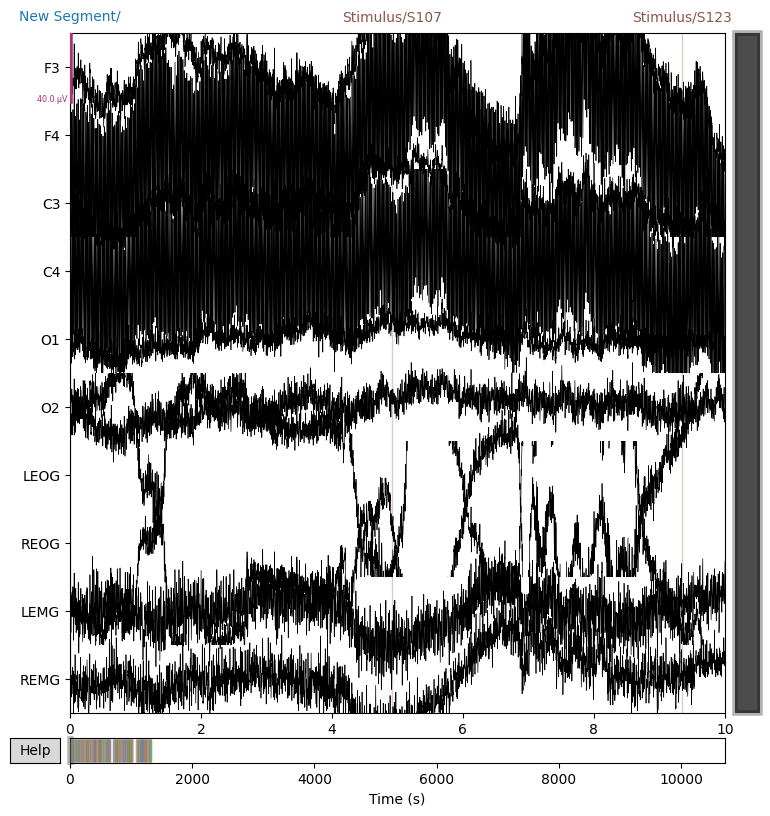

Plotting power spectral density...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Extracting events...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S106', 'Stimulus/S107', 'Stimulus/S109', 'Stimulus/S110', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S117', 'Stimulus/S118', 'Stimulus/S121', 'Stimulus/S123', 'Stimulus/S127', 'Stimulus/S129', 'Stimulus/S130', 'Stimulus/S131', 'Stimulus/S137', 'Stimulus/S138', 'Stimulus/S139', 'Stimulus/S143', 'Stimulus/S144', 'Stimulus/S146', 'Stimulus/S147']
Found 362 events.
Processing: ./ds005530\sub-06102021301\eeg\sub-06102021301_task-sleep_run-01_eeg.eeg
Extracting parameters from ./ds005530\sub-06102021301\eeg\sub-06102021301_task-sleep_run-01_eeg.vhdr...
Setting channel info structure...


C:\Users\rikib\AppData\Local\Temp\ipykernel_2992\4081865487.py:41: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
C:\Users\rikib\miniconda3\envs\fastai\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Reading 0 ... 16173809  =      0.000 ... 32347.618 secs...
EEG Info:
<Info | 7 non-empty values
 bads: []
 ch_names: F3, F4, C3, C4, O1, O2, LEOG, REOG, LEMG, REMG
 chs: 10 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-10-04 23:27:19 UTC
 nchan: 10
 projs: []
 sfreq: 500.0 Hz
>
Plotting raw data...


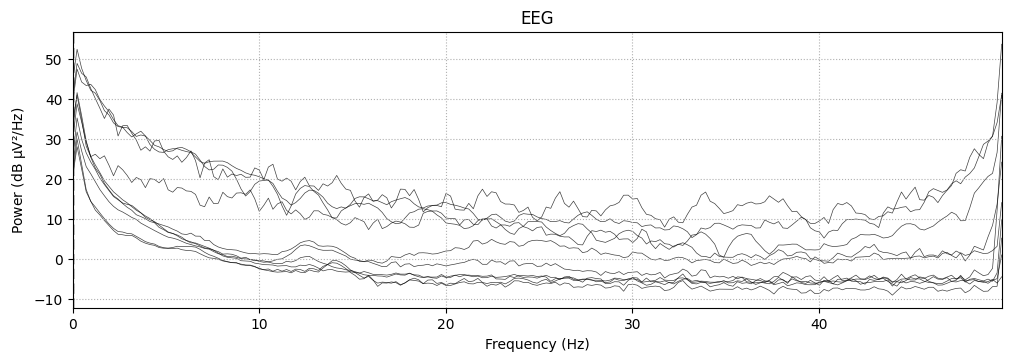

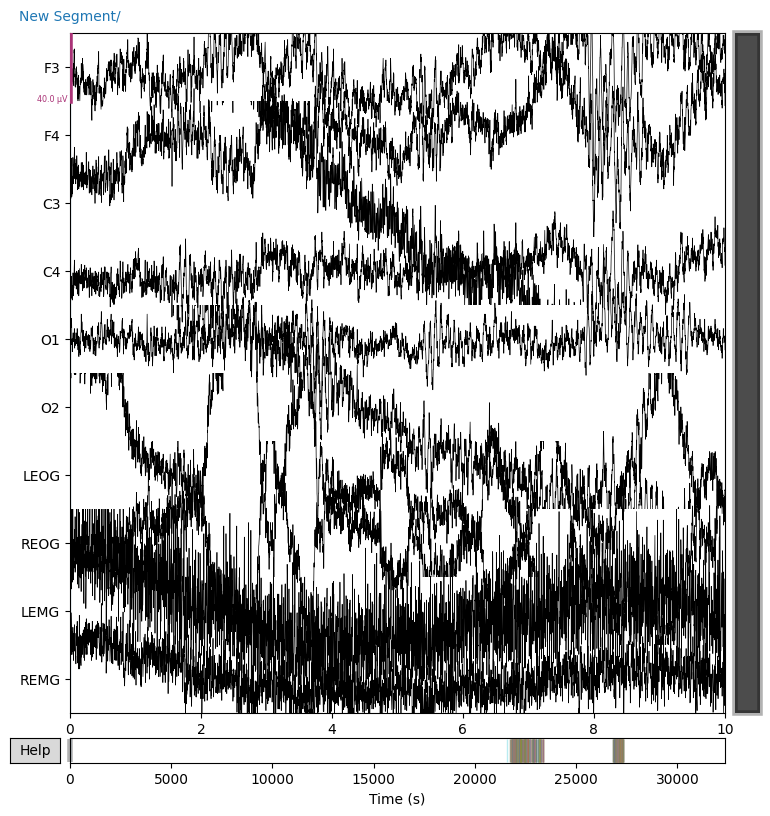

Plotting power spectral density...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)



KeyboardInterrupt



In [10]:
# Example usage
process_eeg_files("./ds005530")